In [1]:
%%javascript
document.title='Jupyter Lab - Oil prices.ipynb'

<IPython.core.display.Javascript object>

In [166]:
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm  
import pandas as pd
import numpy as np
import os
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [22]:
def freq_string_generator(date_dict):
    freq_map = {"seconds" : 'S', 'minutes' : 'T', 'days': 'D', 'months': 'M'}
    freq_string = ''
    
    for k in freq_map:
        if k in date_dict:
            freq_string += str(date_dict[k]) + freq_map[k]
    
    return freq_string

In [25]:
def make_dataset(dir_path=None, split_by_years=False):
    dir_path = './data' if dir_path is None else dir_path
    files = [file for file in glob(DATASET_PATH + '/*') if '.' not in file.split('/')[-1]]
    df = []
    periods = []
    for file in tqdm(files):
        df_ = pd.read_csv(file, header=None)
        df_.columns = [0,1,'price','volume']
        df_['date'] = pd.to_datetime(df_[0] + ' ' + df_[1])
        df_ = df_[['date','price','volume']].set_index('date')
#         df_['file_name'] = file.split('/')[-1]
        #record first and the last date of each file
        file_name = file.split('/')[-1]
        first_entry = df_.iloc[0:1].copy()
        first_entry['file'] = file_name
        last_entry = df_.iloc[-1:].copy()
        last_entry['file'] = file_name
        periods += [first_entry, last_entry]
        df.append(df_)
    df = pd.concat(df).sort_index()
    df.to_csv('oil_dataset.csv')
    
    periods = pd.concat(periods)
    periods.to_csv('periods.csv')
    
    if split_by_years:
        for year in tqdm(df.groupby(pd.Grouper(freq='Y')).count().index.year):
            df_by_year = df.loc[df.index.year == year]
            df_by_year.to_csv('oil_dataset_' + str(year) + '.csv')

In [33]:
def read_dataset(file_path):
    print('Loading dataset from:' , file_path)
    df = pd.read_csv(file_path, index_col=0)
    df.index = pd.to_datetime(df.index).to_period('S')
    return df


In [ ]:
%%time
if os.path.exists('oil_dataset.csv'):
    read_dataset('oil_dataset.csv')
else:
    make_dataset()

    

In [34]:
%%time
df = read_dataset('oil_dataset_2010.csv')
df

Loading dataset from:  oil_dataset_2010.csv
CPU times: user 26 s, sys: 2.01 s, total: 28 s
Wall time: 28.1 s


,price,volume
date,,
2010-01-03 18:00:00,79.63,3
2010-01-03 18:00:00,79.63,4
2010-01-03 18:00:00,79.63,3
2010-01-03 18:00:00,79.63,2
2010-01-03 18:00:00,79.63,2
...,...,...
2010-12-31 16:14:47,91.40,1
2010-12-31 16:14:49,91.40,1
2010-12-31 16:14:50,91.38,2


### I take small subset to test things out

In [ ]:
def resample(df, freq_dict, delta_threshold = 0.005, heatmap=True, bins=25, title=None, fig_size=(8,8)):
    
    if isinstance(freq_dict, str):
        freq_string = freq_dict
    else:
        freq_map = {"seconds" : 'S', 'minutes' : 'T', 'days': 'D', 'months': 'M'}
        freq_string = ''

        for k in freq_map:
            if k in freq_dict and freq_dict[k]:
                freq_string += str(freq_dict[k]) + freq_map[k]
            
    resampled = df.resample(freq_string).agg({"price": ['first', 'last', 'mean']})
    resampled.columns = resampled.columns.droplevel(0)
#     resampled.columns = ['first', 'last', 'average', 'file']
    resampled['delta'] = resampled['last']/resampled['first'] - 1
    resampled['delta_next_time'] = resampled['delta'].shift(-1)
    resampled = resampled.iloc[:-1]
    resampled = resampled.loc[np.abs(resampled['delta']) > 0.95*delta_threshold]
    #check if minimum price change equals three ticks of this contract
    resampled = resampled.loc[np.abs(resampled['delta']) * resampled['mean'] > 0.03]

#     resampled = resampled[['first', 'last', 'average', 'delta', 'delta_next_day']]

    if heatmap:
        bins_suffix = ''
        if bins and bins < resampled.shape[0]:
            #make bins to downsample the data
            bins_suffix = '_bins'
            for column in ['delta', 'delta_next_time']:
                bins_space = np.linspace(resampled[column].min(), resampled[column].max() + 1e-8, bins)
                digitized = np.digitize(resampled[column], bins_space)
                resampled[column + bins_suffix] = np.take(bins_space, digitized)
        
        #crosstab to count every pair 
        cross = pd.crosstab(resampled['delta' + bins_suffix], resampled['delta_next_time' + bins_suffix])
        cross.index, cross.columns = np.round(cross.index,4), np.round(cross.columns,4)
        cross.index.name, cross.columns.name = 'delta', 'delta_next_time'
        cross = cross.iloc[::-1]

        fig, ax = plt.subplots(figsize=fig_size)
#         fig.suptitle(title if title else str(resampled.index[0].year))
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])   
        title = title if title else f'''Deltas and times pairs in {resampled.index[0].year} with {delta_threshold} delta threshold
                \n and {freq_dict} time'''
        ax.text(0.1, 1.05, title, transform=ax.transAxes, size=12, fontdict=None, weight='bold')

        heatmap = sns.heatmap(cross, ax=ax,cbar=True, cbar_kws={"shrink": .65}, square=True)
        plt.yticks(rotation=0) 
        plt.xticks(rotation=30)
        ax.set_aspect('equal','box')
#         ax.set_ylim(resampled['delta' + bins_suffix].min(), resampled['delta' + bins_suffix].max())
#         ax.set_xlim(resampled['delta_next_time' + bins_suffix].min(), resampled['delta_next_time' + bins_suffix].max())
#         ax.set_aspect("equal")
        plt.axis('scaled')
        plt.show()
    
    return resampled
    

### Heatmap

Loading dataset from:  oil_dataset_2010.csv


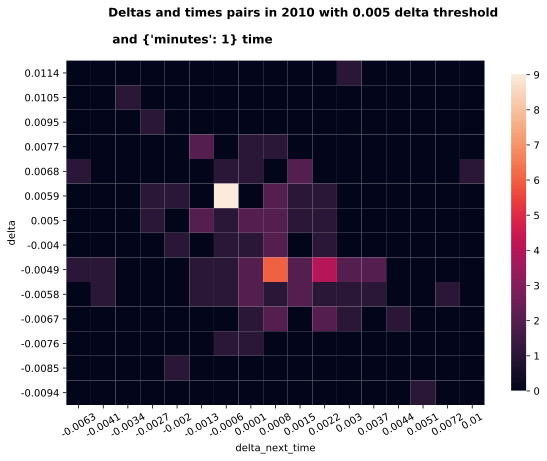

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2010-01-06 10:30,82.16,81.49,81.616647,-0.008155,-0.000736,-0.007622,-0.000590
2010-01-06 11:21,81.95,82.67,82.267513,0.008786,-0.003145,0.009547,-0.002718
2010-01-12 16:30,80.55,80.16,80.300313,-0.004842,-0.001123,-0.004008,-0.000590
2010-01-13 10:30,79.06,78.47,78.703080,-0.007463,0.002039,-0.006719,0.002247
2010-01-21 11:09,77.12,76.49,76.928212,-0.008169,0.000000,-0.007622,0.000119
...,...,...,...,...,...,...,...
2010-11-03 14:16,84.33,84.88,84.703099,0.006522,0.000000,0.006836,0.000119
2010-11-09 16:30,85.95,86.36,86.153450,0.004770,-0.000347,0.005029,0.000119
2010-11-24 10:59,82.43,82.89,82.695039,0.005580,0.000603,0.005933,0.000828


Loading dataset from:  oil_dataset_2011.csv


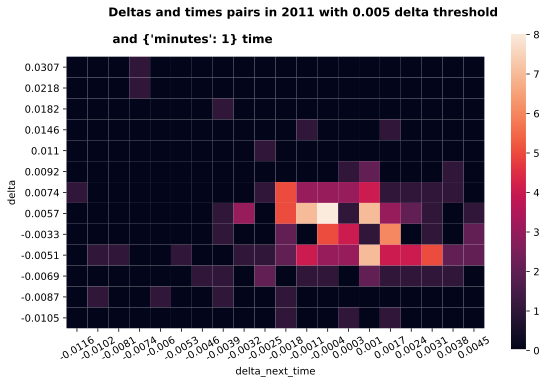

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2011-01-10 13:27,88.84,89.28,89.092504,0.004953,0.000336,0.005654,0.001026
2011-02-09 13:07,86.79,87.22,87.037651,0.004954,-0.000917,0.005654,-0.000373
2011-02-11 11:06,86.10,85.68,85.823431,-0.004878,0.002567,-0.003305,0.003124
2011-02-22 10:37,94.61,94.12,94.324668,-0.005179,0.000744,-0.005097,0.001026
2011-02-24 02:55,101.46,103.30,102.600835,0.018135,-0.004462,0.018196,-0.003871
...,...,...,...,...,...,...,...
2011-11-07 06:59,94.54,94.09,94.282138,-0.004760,0.004039,-0.003305,0.004523
2011-11-30 08:00,99.68,100.55,100.293450,0.008728,0.003282,0.009237,0.003824
2011-12-13 09:45,99.35,100.63,100.275484,0.012884,-0.001391,0.014613,-0.001073


Loading dataset from:  oil_dataset_2012.csv


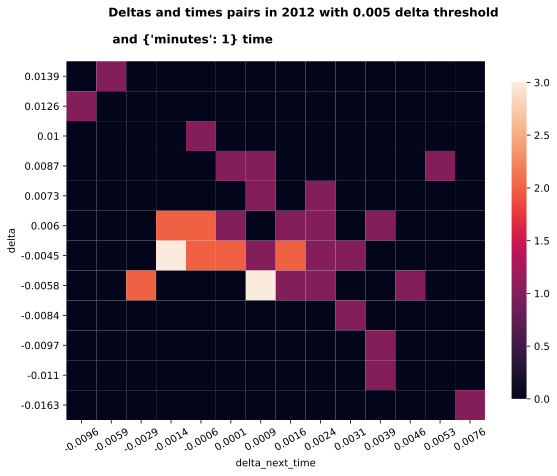

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2012-01-12 14:15,99.79,99.17,99.489270,-0.006213,0.001008,-0.005771,0.001605
2012-01-12 14:28,99.50,98.97,99.181015,-0.005327,0.000909,-0.004459,0.001605
2012-01-20 09:02,99.74,99.26,99.431012,-0.004813,0.000604,-0.004459,0.000856
2012-01-25 13:15,99.88,100.37,100.153664,0.004906,-0.001893,0.006036,-0.001390
2012-02-13 09:01,100.01,100.52,100.278910,0.005099,-0.001094,0.006036,-0.000641
2012-03-15 11:38,104.50,103.89,104.098790,-0.005837,0.003946,-0.005771,0.004599
2012-03-15 12:02,104.20,105.16,104.744407,0.009213,-0.001236,0.009972,-0.000641
2012-03-23 09:55,106.42,107.90,107.209053,0.013907,-0.006210,0.013907,-0.005881
2012-03-23 09:56,107.89,107.22,107.630711,-0.006210,-0.003544,-0.005771,-0.002887


Loading dataset from:  oil_dataset_2013.csv


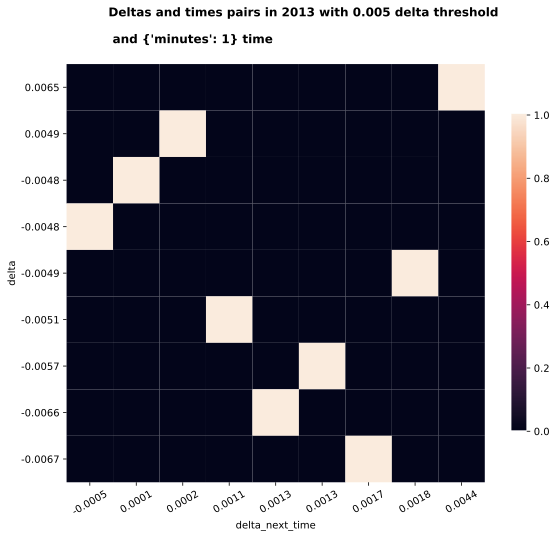

,first,last,mean,delta,delta_next_time
date,,,,,
2013-02-15 09:15,96.22,95.76,95.941284,-0.004781,-0.000522
2013-02-20 11:01,95.81,95.18,95.374374,-0.006576,0.001261
2013-04-05 08:30,92.65,92.03,92.142726,-0.006692,0.001739
2013-05-03 08:30,94.29,94.90,94.702142,0.006469,0.004426
2013-05-07 10:13,95.61,95.14,95.353532,-0.004916,0.001787
2013-05-14 14:00,94.73,94.28,94.392152,-0.004750,0.000106
2013-08-21 10:31,104.93,104.39,104.644671,-0.005146,0.001054
2013-10-02 10:32,102.40,102.90,102.726210,0.004883,0.000194
2013-10-09 10:30,102.01,101.43,101.603697,-0.005686,0.001282


Loading dataset from:  oil_dataset_2014.csv


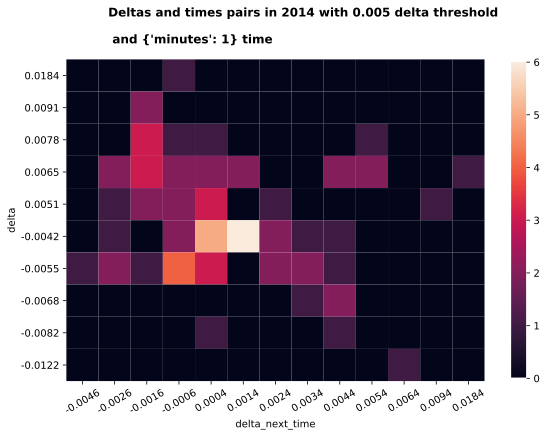

,first,last,mean,delta,delta_next_time,delta_bins,delta_next_time_bins
date,,,,,,,
2014-03-02 18:00,103.00,103.73,103.403481,0.007087,-0.001928,0.007794,-0.001630
2014-04-08 12:40,101.78,102.31,102.090701,0.005207,0.000489,0.006464,0.001380
2014-09-30 11:34,92.76,92.20,92.359258,-0.006037,-0.001193,-0.005507,-0.000627
2014-10-07 23:38,88.31,87.84,87.995224,-0.005322,0.000911,-0.004177,0.001380
2014-10-14 14:30,81.81,81.33,81.689760,-0.005867,0.003686,-0.005507,0.004390
...,...,...,...,...,...,...,...
2014-12-26 04:01,56.20,55.91,56.019023,-0.005160,0.000536,-0.004177,0.001380
2014-12-28 19:01,55.34,55.62,55.494469,0.005060,-0.000899,0.005134,-0.000627
2014-12-29 12:16,54.06,53.68,53.857968,-0.007029,0.002422,-0.006837,0.003386


In [203]:
for year in [2010, 2011, 2012, 2013, 2014]:
    df = read_dataset(f'oil_dataset_{year}.csv')
    out = resample(df,dict(minutes=1), delta_threshold=0.005)
    display(out)

In [181]:
# out = resample(df,dict(seconds=0, minutes=1), delta_threshold=0.005)
# out